# Reading file, Dropping Unnecessary Columns, Outlier Analysis

In [2]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv(r'C:\Users\Utku\Desktop\train.csv')

# Columns to be dropped
columns_to_drop = ["occupation_type", "migrant_worker", "name", "prev_defaults", "default_in_last_6months"]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# 1. Identify numerical columns (excluding the target variable)
target_col = "credit_card_default"
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != target_col]

# 2. Get the initial number of missing (NaN) cells
initial_missing_cells = df.isnull().sum().sum()

# 3. Calculate and store IQR bounds for each numerical column (only once)
iqr_bounds = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_bounds[col] = (lower, upper)

# 4. Count the number of outlier cells before any modifications
initial_outlier_cells = 0
for col in num_cols:
    lower, upper = iqr_bounds[col]
    initial_outlier_cells += ((df[col] < lower) | (df[col] > upper)).sum()

# 5. Create a DataFrame to flag outlier cells (True/False) for each column
outlier_flags = pd.DataFrame(index=df.index)
for col in num_cols:
    lower, upper = iqr_bounds[col]
    outlier_flags[col] = (df[col] < lower) | (df[col] > upper)

# 6. Count the number of outliers per row
outlier_count_per_row = outlier_flags.sum(axis=1)

# 7. Remove rows with 3 or more outliers
rows_to_drop = outlier_count_per_row[outlier_count_per_row >= 3].index
df_step1 = df.drop(index=rows_to_drop)

# 8. Replace remaining outlier values with NaN in the remaining data
df = df_step1.copy()
for col in num_cols:
    lower, upper = iqr_bounds[col]
    df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan

# 9. Count the final number of missing (NaN) cells
final_missing_cells = df.isnull().sum().sum()

# 10. Calculate the number of cells turned into NaN due to outliers
outlier_cells_removed = final_missing_cells - initial_missing_cells

# 11. Print the results
print(f"There were initially {initial_missing_cells} missing (NaN) cells.")
print(f"There were initially {initial_outlier_cells} outlier cells.")
print(f"{outlier_cells_removed} cells were converted to NaN due to outliers.")

# Optionally save the result
df.to_csv(r'C:\Users\Utku\Desktop\train_final1.csv', index=False)


Başlangıçta 1970 boş (NaN) hücre vardı.
Başlangıçta 14464 outlier hücre vardı.
Outlier nedeniyle 13430 hücre NaN yapıldı.


# Filling Null Cells

In [20]:
import pandas as pd
import numpy as np

df_cleaned = pd.read_csv(r'C:\Users\Utku\Desktop\train_final1.csv')

# Fill missing 'credit_limit' values with the median of those having credit_score > 600
median_credit_limit = df_cleaned[df_cleaned['credit_score'] > 600]['credit_limit'].median()
df_cleaned['credit_limit'].fillna(median_credit_limit, inplace=True)

# Define age bin edges and corresponding labels
age_bins = [18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 100]
age_labels = ['18-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-60', '60-70', '70+']

# Temporary function to assign an age group label based on age
def get_age_group(age):
    for i in range(len(age_bins)-1):
        if age_bins[i] <= age < age_bins[i+1]:
            return age_labels[i]
    return np.nan

# Compute the median net_yearly_income for each age group
df_cleaned['temp_age_group'] = df_cleaned['age'].apply(get_age_group)
median_income_by_age = df_cleaned.groupby('temp_age_group')['net_yearly_income'].median()

# Fill missing 'net_yearly_income' based on median income of the corresponding age group
def fill_income(row):
    if pd.isna(row['net_yearly_income']):
        return median_income_by_age.get(row['temp_age_group'], np.nan)
    return row['net_yearly_income']

df_cleaned['net_yearly_income'] = df_cleaned.apply(fill_income, axis=1)

# Compute the median number of employment days for each age group
median_days_by_age = df_cleaned.groupby('temp_age_group')['no_of_days_employed'].median()

# Fill missing 'no_of_days_employed' based on the median of the corresponding age group
def fill_days_employed(row):
    if pd.isna(row['no_of_days_employed']):
        return median_days_by_age.get(row['temp_age_group'], np.nan)
    return row['no_of_days_employed']

df_cleaned['no_of_days_employed'] = df_cleaned.apply(fill_days_employed, axis=1)

# Remove the temporary age group column
df_cleaned.drop(columns=['temp_age_group'], inplace=True)

# Fill missing 'no_of_children' values with the median of individuals having at least 2 family members
median_children = df_cleaned[df_cleaned['total_family_members'] >= 2]['no_of_children'].median()
df_cleaned['no_of_children'].fillna(median_children, inplace=True)

# Fill missing 'total_family_members' values with the overall median
df_cleaned['total_family_members'].fillna(df_cleaned['total_family_members'].median(), inplace=True)

# Define income bin edges using quantiles (temporary function will be used)
income_bins = df_cleaned['net_yearly_income'].quantile(q=np.linspace(0,1,11)).values

# Temporary function to assign an income group based on quantile bins
def get_income_group(income):
    for i in range(len(income_bins)-1):
        if income_bins[i] <= income <= income_bins[i+1]:
            return i
    return np.nan

df_cleaned['temp_income_group'] = df_cleaned['net_yearly_income'].apply(get_income_group)

# Compute the median yearly_debt_payments for each income group
median_debt_by_income = df_cleaned.groupby('temp_income_group')['yearly_debt_payments'].median()

# Fill missing 'yearly_debt_payments' values based on median of the corresponding income group
def fill_debt(row):
    if pd.isna(row['yearly_debt_payments']):
        return median_debt_by_income.get(row['temp_income_group'], np.nan)
    return row['yearly_debt_payments']

df_cleaned['yearly_debt_payments'] = df_cleaned.apply(fill_debt, axis=1)

# Compute the mode of 'owns_car' for each income group
mode_car_by_income = df_cleaned.groupby('temp_income_group')['owns_car'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Fill missing 'owns_car' values based on mode of the corresponding income group
def fill_owns_car(row):
    if pd.isna(row['owns_car']):
        return mode_car_by_income.get(row['temp_income_group'], np.nan)
    return row['owns_car']

df_cleaned['owns_car'] = df_cleaned.apply(fill_owns_car, axis=1)

# Remove the temporary income group column
df_cleaned.drop(columns=['temp_income_group'], inplace=True)

# Fill missing 'credit_score' values with the overall median
df_cleaned['credit_score'].fillna(df_cleaned['credit_score'].median(), inplace=True)

# Save the final cleaned dataset
df_cleaned.to_csv(r'C:\Users\Utku\Desktop\train_full.csv', index=False)


C:\Users\UTKU\AppData\Local\Temp\ipykernel_16964\2849692310.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['credit_limit'].fillna(median_credit_limit, inplace=True)
C:\Users\UTKU\AppData\Local\Temp\ipykernel_16964\2849692310.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

# Split The Dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r'C:\Users\Utku\Desktop\train_full.csv')

# First, split the data into 80% train+validation and 20% test
train_val, test = train_test_split(df, test_size=0.2, random_state=42)

# Then, split the 80% train+validation set into 75% train and 25% validation
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.20

# Final proportions:
# train: 60%, validation: 20%, test: 20%

print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Test set shape: {test.shape}")


Train set shape: (27122, 14)
Validation set shape: (9041, 14)
Test set shape: (9041, 14)


# Smote Application

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

X = train.drop('credit_card_default', axis=1)  # Drop the target column to get the features
y = train['credit_card_default']  # Define the target variable

# 4. Convert categorical variables into numeric format using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 5. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 6. Create a new DataFrame with the SMOTE-applied features and target
train_smote = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='credit_card_default')], axis=1)

# 7. Print dataset shapes and class distributions before and after SMOTE
print(f"Original shape: {X.shape}, Class distribution: \n{y.value_counts()}")
print(f"SMOTE shape: {X_res.shape}, Class distribution: \n{y_res.value_counts()}")

# (Optional) Save the SMOTE-augmented training set to a CSV file
# train_smote.to_csv('train_smote.csv', index=False)


Original shape: (27122, 13), Class distribution: 
credit_card_default
0    24946
1     2176
Name: count, dtype: int64
SMOTE shape: (49892, 13), Class distribution: 
credit_card_default
0    24946
1    24946
Name: count, dtype: int64


# Hyperparameter Tuning

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def tune_and_test_model(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n🔍 Tuning: {model_name}...\n")
    
    # Perform grid search with 5-fold cross-validation using F1 score as the evaluation metric
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_res, y_res)
    
    print(f"✅ Best Params for {model_name}: {grid.best_params_}\n")
    
    # Evaluate the model on the test set
    y_test_pred = grid.predict(X_test)
    print(f"📊 {model_name} - Test Confusion Matrix")
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    
    return grid


In [7]:
# Define hyperparameter grids for each model
log_params = {
    'C': [0.01, 0.1, 1, 10],                  # Regularization strength for Logistic Regression
    'penalty': ['l1', 'l2'],                  # Type of regularization
    'solver': ['liblinear']                   # Solver compatible with L1 and L2 penalties
}

rf_params = {
    'n_estimators': [100, 200],               # Number of trees in the forest
    'max_depth': [5, 10, None],               # Maximum depth of each tree
    'min_samples_split': [2, 5]               # Minimum number of samples required to split an internal node
}

xgb_params = {
    'n_estimators': [100, 200],               # Number of boosting rounds
    'max_depth': [3, 5, 7],                   # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2]         # Step size shrinkage to prevent overfitting
}

# Model training and evaluation using the SMOTE-applied training data (validation set is not used anymore)
log_model = tune_and_test_model(
    'Logistic Regression',
    LogisticRegression(max_iter=1000),
    log_params,
    X_res, y_res, X_test, y_test
)

rf_model = tune_and_test_model(
    'Random Forest',
    RandomForestClassifier(random_state=42),
    rf_params,
    X_res, y_res, X_test, y_test
)

xgb_model = tune_and_test_model(
    '



🔍 Tuning: Logistic Regression...

✅ Best Params for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

📊 Logistic Regression - Test Confusion Matrix
[[7947  325]
 [  57  712]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8272
           1       0.69      0.93      0.79       769

    accuracy                           0.96      9041
   macro avg       0.84      0.94      0.88      9041
weighted avg       0.97      0.96      0.96      9041


🔍 Tuning: Random Forest...

✅ Best Params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

📊 Random Forest - Test Confusion Matrix
[[8140  132]
 [ 124  645]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8272
           1       0.83      0.84      0.83       769

    accuracy                           0.97      9041
   macro avg       0.91      0.91      0.91      9041
weighte

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}

📊 XGBoost - Test Confusion Matrix
[[8155  117]
 [ 150  619]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8272
           1       0.84      0.80      0.82       769

    accuracy                           0.97      9041
   macro avg       0.91      0.90      0.90      9041
weighted avg       0.97      0.97      0.97      9041



In [9]:
# Separate features and target from the validation set
X_val = val.drop('credit_card_default', axis=1)
y_val = val['credit_card_default']

# Convert categorical variables in the validation set to numerical using Label Encoding
for col in X_val.select_dtypes(include='object').columns:
    X_val[col] = LabelEncoder().fit_transform(X_val[col])


# Model Run With Default Data


🔷 Logistic Regression - TRAIN
[[24737   209]
 [  511  1665]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     24946
           1       0.89      0.77      0.82      2176

    accuracy                           0.97     27122
   macro avg       0.93      0.88      0.90     27122
weighted avg       0.97      0.97      0.97     27122

Accuracy (Train): 0.9735
F1-Score (Macro, Train): 0.9039
F1-Score (Weighted, Train): 0.9725
Log Loss (Train): 0.0610

🔶 Logistic Regression - TEST
[[8204   68]
 [ 182  587]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8272
           1       0.90      0.76      0.82       769

    accuracy                           0.97      9041
   macro avg       0.94      0.88      0.90      9041
weighted avg       0.97      0.97      0.97      9041

Accuracy (Test): 0.9723
F1-Score (Macro, Test): 0.9047
F1-Score (Weighted, Test): 0.9713
Log Loss (Test): 0.06

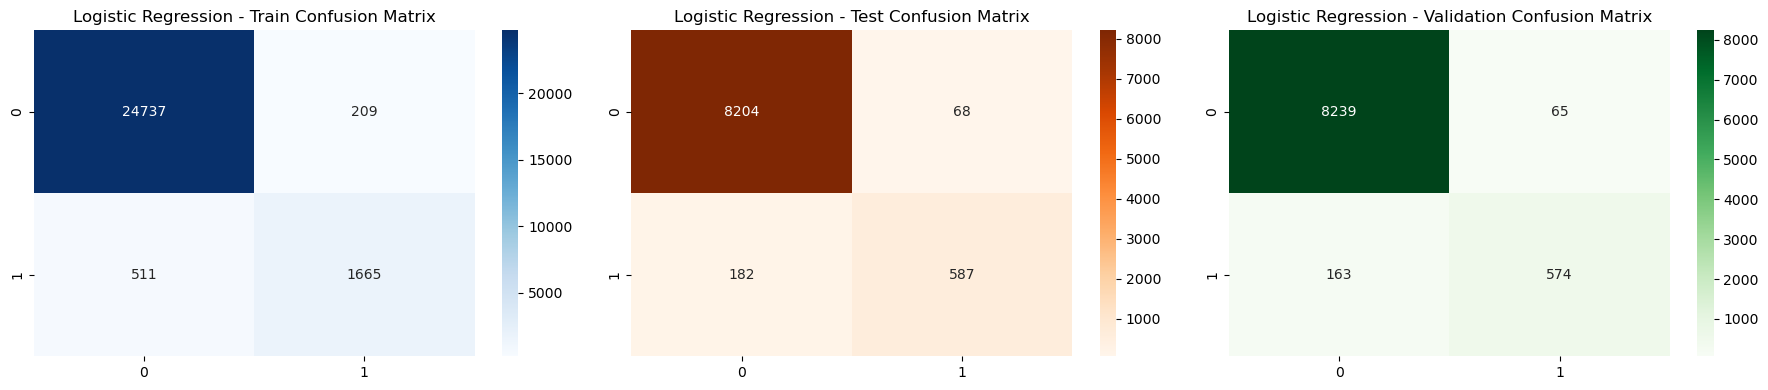


🔷 Random Forest - TRAIN
[[24946     0]
 [    0  2176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       1.00      1.00      1.00      2176

    accuracy                           1.00     27122
   macro avg       1.00      1.00      1.00     27122
weighted avg       1.00      1.00      1.00     27122

Accuracy (Train): 1.0000
F1-Score (Macro, Train): 1.0000
F1-Score (Weighted, Train): 1.0000
Log Loss (Train): 0.0128

🔶 Random Forest - TEST
[[8265    7]
 [ 184  585]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8272
           1       0.99      0.76      0.86       769

    accuracy                           0.98      9041
   macro avg       0.98      0.88      0.92      9041
weighted avg       0.98      0.98      0.98      9041

Accuracy (Test): 0.9789
F1-Score (Macro, Test): 0.9241
F1-Score (Weighted, Test): 0.9776
Log Loss (Test): 0.0493

🔶 Random

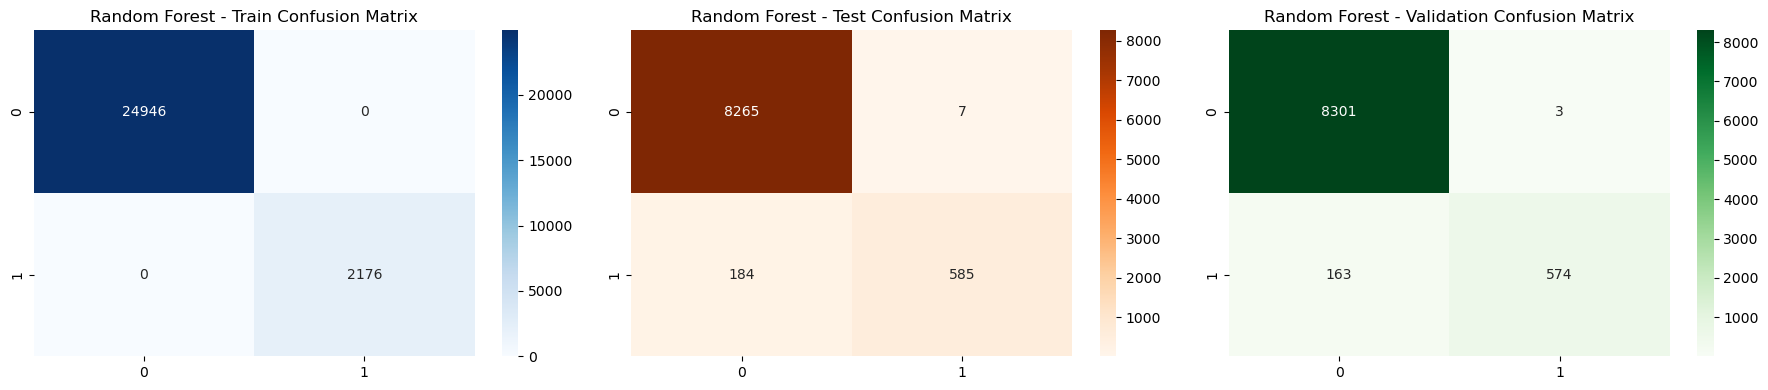

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:59:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔷 XGBoost - TRAIN
[[24946     0]
 [    0  2176]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       1.00      1.00      1.00      2176

    accuracy                           1.00     27122
   macro avg       1.00      1.00      1.00     27122
weighted avg       1.00      1.00      1.00     27122

Accuracy (Train): 1.0000
F1-Score (Macro, Train): 1.0000
F1-Score (Weighted, Train): 1.0000
Log Loss (Train): 0.0031

🔶 XGBoost - TEST
[[8211   61]
 [ 161  608]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8272
           1       0.91      0.79      0.85       769

    accuracy                           0.98      9041
   macro avg       0.94      0.89      0.92      9041
weighted avg       0.97      0.98      0.97      9041

Accuracy (Test): 0.9754
F1-Score (Macro, Test): 0.9161
F1-Score (Weighted, Test): 0.9747
Log Loss (Test): 0.0620

🔶 XGBoost - VALIDATI

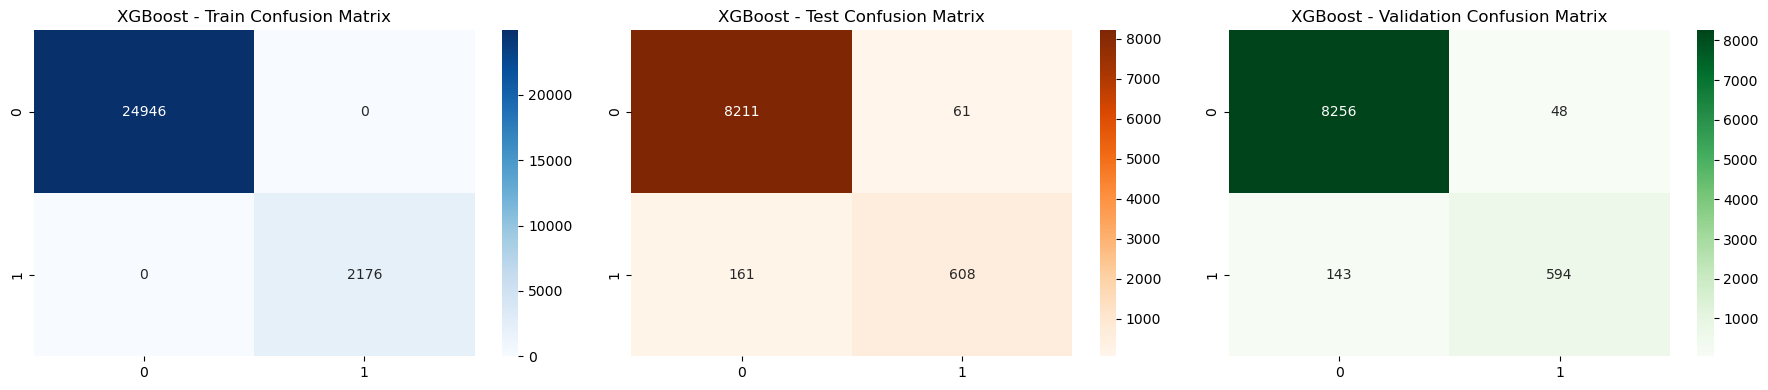

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

# Split the test dataset into features (X_test) and target variable (y_test)
X_test = test.drop('credit_card_default', axis=1)
y_test = test['credit_card_default']

# Split the training dataset into features (X_traindef) and target variable (y_traindef)
X_traindef = train.drop('credit_card_default', axis=1)
y_traindef = train['credit_card_default']

# Split the validation dataset into features (X_val) and target variable (y_val)
X_val = val.drop('credit_card_default', axis=1)
y_val = val['credit_card_default']

# Encode categorical variables in the validation set
for col in val.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    val[col] = le.fit_transform(val[col])

# Encode categorical variables in the training set
for col in train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

# Encode categorical variables in the test set
# Note: In real projects, the encoder fitted on the training data should be used here
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

def evaluate_model(model, model_name):
    """
    Trains the model on the training data, then evaluates and prints performance metrics
    on training, test, and validation datasets. Also visualizes confusion matrices.
    """

    # Train the model with training data
    model.fit(X_traindef, y_traindef)

    # Make predictions
    y_train_pred = model.predict(X_traindef)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    # If the model supports probability estimates, get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_traindef)
        y_test_proba = model.predict_proba(X_test)
        y_val_proba = model.predict_proba(X_val)
    else:
        y_train_proba = None
        y_test_proba = None
        y_val_proba = None

    # Training set results
    print(f"\n🔷 {model_name} - TRAIN")
    cm_train = confusion_matrix(y_traindef, y_train_pred)
    print(cm_train)
    print(classification_report(y_traindef, y_train_pred))
    print(f"Accuracy (Train): {accuracy_score(y_traindef, y_train_pred):.4f}")
    print(f"F1-Score (Macro, Train): {f1_score(y_traindef, y_train_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Train): {f1_score(y_traindef, y_train_pred, average='weighted'):.4f}")
    if y_train_proba is not None:
        print(f"Log Loss (Train): {log_loss(y_traindef, y_train_proba):.4f}")

    # Test set results
    print(f"\n🔶 {model_name} - TEST")
    cm_test = confusion_matrix(y_test, y_test_pred)
    print(cm_test)
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"F1-Score (Macro, Test): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    if y_test_proba is not None:
        print(f"Log Loss (Test): {log_loss(y_test, y_test_proba):.4f}")

    # Validation set results
    print(f"\n🔶 {model_name} - VALIDATION")
    cm_val = confusion_matrix(y_val, y_val_pred)
    print(cm_val)
    print(classification_report(y_val, y_val_pred))
    print(f"Accuracy (Validation): {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"F1-Score (Macro, Validation): {f1_score(y_val, y_val_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
    if y_val_proba is not None:
        print(f"Log Loss (Validation): {log_loss(y_val, y_val_proba):.4f}")

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title(f'{model_name} - Train Confusion Matrix')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Oranges')
    axes[1].set_title(f'{model_name} - Test Confusion Matrix')

    sns.heatmap(cm_val, annot=True, fmt='d', ax=axes[2], cmap='Greens')
    axes[2].set_title(f'{model_name} - Validation Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Create and evaluate tuned Logistic Regression model
lr_model = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
evaluate_model(lr_model, "Logistic Regression")

# Create and evaluate tuned Random Forest model
rf_model = RandomForestClassifier(
    max_depth=None,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
evaluate_model(rf_model, "Random Forest")

# Create and evaluate tuned XGBoost model
xgb_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
evaluate_model(xgb_model, "XGBoost")


# Model Run With Smote


🔷 Logistic Regression - TRAIN
[[23949   997]
 [  546 24400]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     24946
           1       0.96      0.98      0.97     24946

    accuracy                           0.97     49892
   macro avg       0.97      0.97      0.97     49892
weighted avg       0.97      0.97      0.97     49892

Accuracy (Train): 0.9691
F1-Score (Macro, Train): 0.9691
F1-Score (Weighted, Train): 0.9691
Log Loss (Train): 0.0757

🔶 Logistic Regression - TEST
[[7950  322]
 [  57  712]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8272
           1       0.69      0.93      0.79       769

    accuracy                           0.96      9041
   macro avg       0.84      0.94      0.88      9041
weighted avg       0.97      0.96      0.96      9041

Accuracy (Test): 0.9581
F1-Score (Macro, Test): 0.8833
F1-Score (Weighted, Test): 0.9608
Log Loss (Test): 0.08

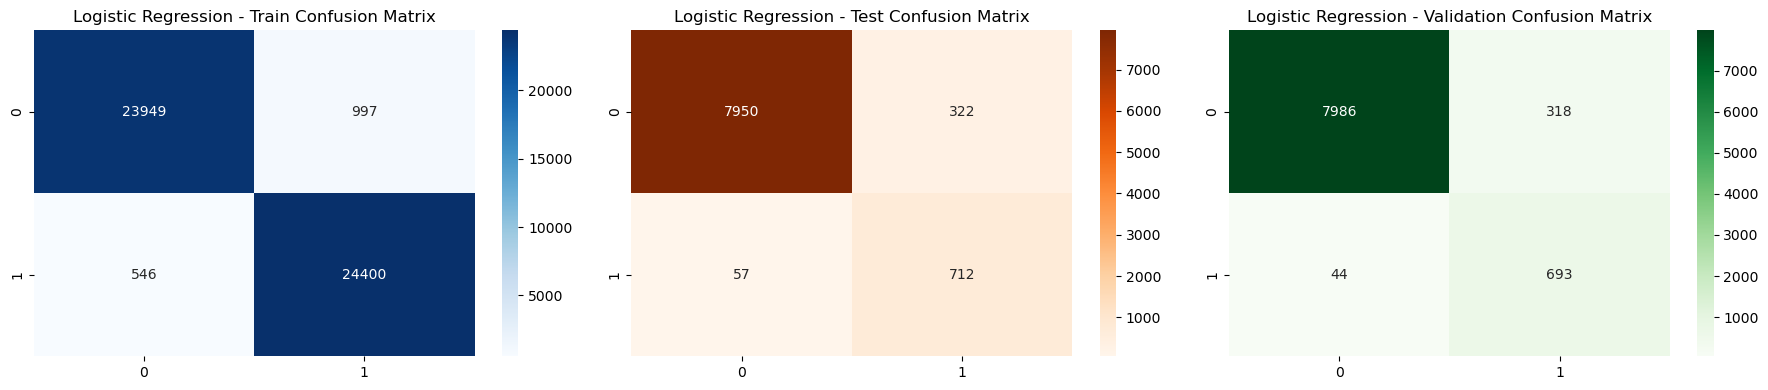


🔷 Random Forest - TRAIN
[[24946     0]
 [    0 24946]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       1.00      1.00      1.00     24946

    accuracy                           1.00     49892
   macro avg       1.00      1.00      1.00     49892
weighted avg       1.00      1.00      1.00     49892

Accuracy (Train): 1.0000
F1-Score (Macro, Train): 1.0000
F1-Score (Weighted, Train): 1.0000
Log Loss (Train): 0.0101

🔶 Random Forest - TEST
[[8140  132]
 [ 124  645]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8272
           1       0.83      0.84      0.83       769

    accuracy                           0.97      9041
   macro avg       0.91      0.91      0.91      9041
weighted avg       0.97      0.97      0.97      9041

Accuracy (Test): 0.9717
F1-Score (Macro, Test): 0.9095
F1-Score (Weighted, Test): 0.9718
Log Loss (Test): 0.0543

🟢 Random

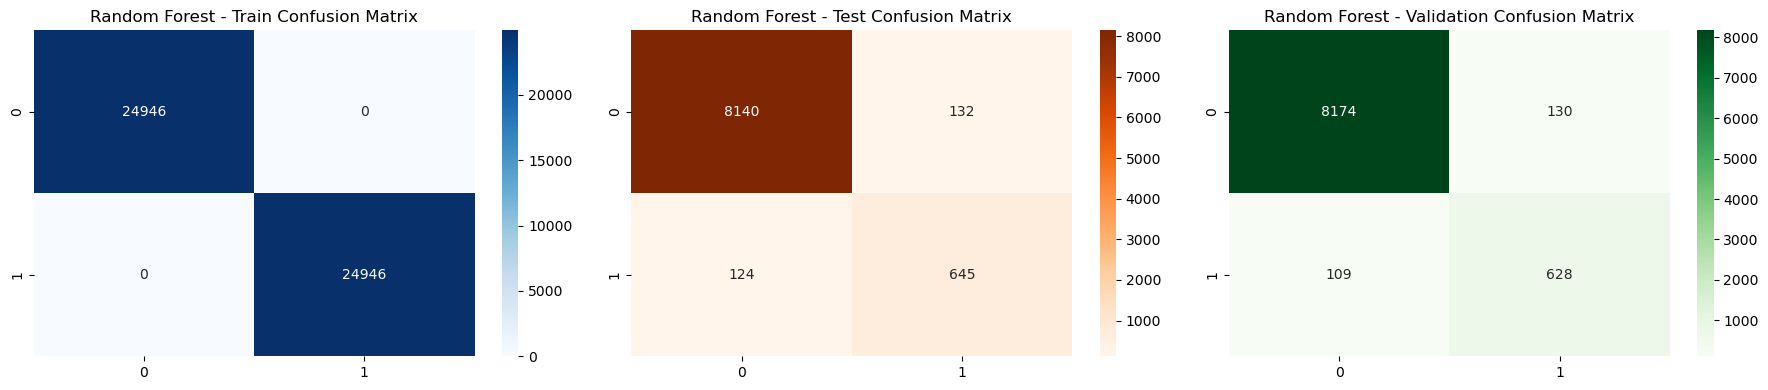

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:01:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔷 XGBoost - TRAIN
[[24946     0]
 [    0 24946]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       1.00      1.00      1.00     24946

    accuracy                           1.00     49892
   macro avg       1.00      1.00      1.00     49892
weighted avg       1.00      1.00      1.00     49892

Accuracy (Train): 1.0000
F1-Score (Macro, Train): 1.0000
F1-Score (Weighted, Train): 1.0000
Log Loss (Train): 0.0025

🔶 XGBoost - TEST
[[8155  117]
 [ 150  619]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8272
           1       0.84      0.80      0.82       769

    accuracy                           0.97      9041
   macro avg       0.91      0.90      0.90      9041
weighted avg       0.97      0.97      0.97      9041

Accuracy (Test): 0.9705
F1-Score (Macro, Test): 0.9032
F1-Score (Weighted, Test): 0.9702
Log Loss (Test): 0.0665

🟢 XGBoost - VALIDATI

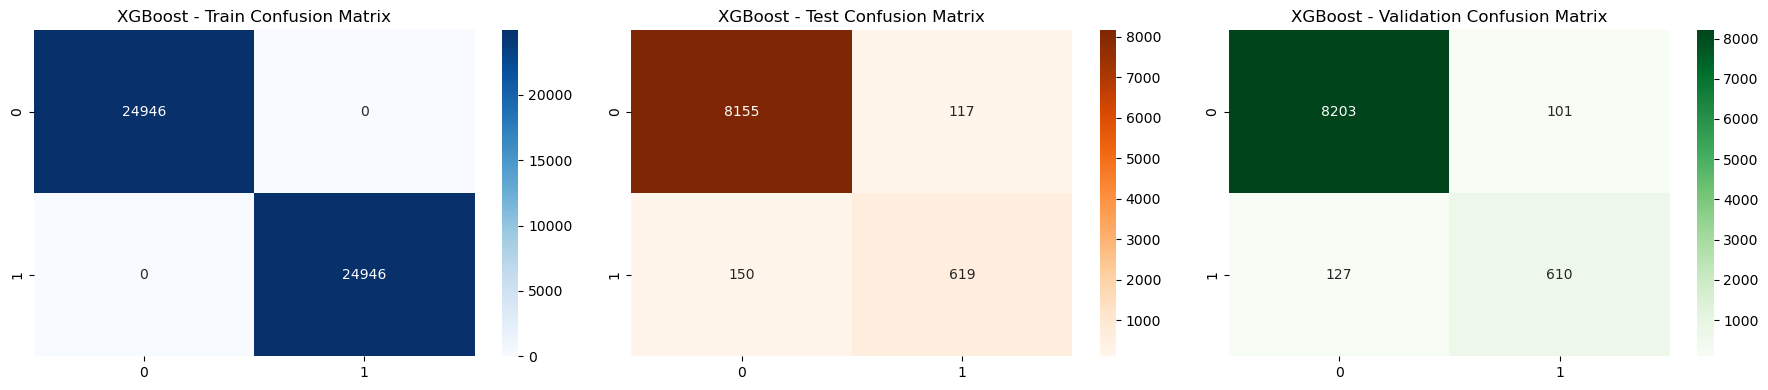

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

# Split test data into features and target
X_test = test.drop('credit_card_default', axis=1)
y_test = test['credit_card_default']

# Apply encoding on test set categorical features
# Note: In practice, use the encoder fitted on training data to transform test data
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

# Split training data (already balanced with SMOTE) into features and target
X_train = train_smote.drop('credit_card_default', axis=1)
y_train = train_smote['credit_card_default']

def evaluate_model(model, model_name):
    """
    Train the model on training data and evaluate on train, test, and validation sets.
    Prints performance metrics and visualizes confusion matrices.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)

    # Get probability predictions if available (for log loss calculation)
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
        y_test_proba = model.predict_proba(X_test)
        y_val_proba = model.predict_proba(X_val)
    else:
        y_train_proba = y_test_proba = y_val_proba = None

    # --- TRAIN RESULTS ---
    print(f"\n🔷 {model_name} - TRAIN")
    cm_train = confusion_matrix(y_train, y_train_pred)
    print(cm_train)
    print(classification_report(y_train, y_train_pred))
    print(f"Accuracy (Train): {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"F1-Score (Macro, Train): {f1_score(y_train, y_train_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Train): {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
    if y_train_proba is not None:
        print(f"Log Loss (Train): {log_loss(y_train, y_train_proba):.4f}")

    # --- TEST RESULTS ---
    print(f"\n🔶 {model_name} - TEST")
    cm_test = confusion_matrix(y_test, y_test_pred)
    print(cm_test)
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"F1-Score (Macro, Test): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    if y_test_proba is not None:
        print(f"Log Loss (Test): {log_loss(y_test, y_test_proba):.4f}")

    # --- VALIDATION RESULTS ---
    print(f"\n🟢 {model_name} - VALIDATION")
    cm_val = confusion_matrix(y_val, y_val_pred)
    print(cm_val)
    print(classification_report(y_val, y_val_pred))
    print(f"Accuracy (Validation): {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"F1-Score (Macro, Validation): {f1_score(y_val, y_val_pred, average='macro'):.4f}")
    print(f"F1-Score (Weighted, Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
    if y_val_proba is not None:
        print(f"Log Loss (Validation): {log_loss(y_val, y_val_proba):.4f}")

    # --- PLOT CONFUSION MATRICES ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title(f'{model_name} - Train Confusion Matrix')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Oranges')
    axes[1].set_title(f'{model_name} - Test Confusion Matrix')

    sns.heatmap(cm_val, annot=True, fmt='d', ax=axes[2], cmap='Greens')
    axes[2].set_title(f'{model_name} - Validation Confusion Matrix')

    plt.tight_layout()
    plt.show()


# Logistic Regression (tuned)
lr_model = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
evaluate_model(lr_model, "Logistic Regression")

# Random Forest (tuned)
rf_model = RandomForestClassifier(
    max_depth=None,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
evaluate_model(rf_model, "Random Forest")

# XGBoost (tuned)
xgb_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
evaluate_model(xgb_model, "XGBoost")


# Model Run With Cross Validation


🔵 Logistic Regression - 5-Fold CV Training on Train Set


C:\Users\UTKU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1 - F1-score: 0.9587


C:\Users\UTKU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2 - F1-score: 0.9556


C:\Users\UTKU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3 - F1-score: 0.9621


C:\Users\UTKU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4 - F1-score: 0.9615


C:\Users\UTKU\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5 - F1-score: 0.9563

🔷 Logistic Regression - Train Set Results
[[24601   345]
 [  732  1444]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     24946
           1       0.81      0.66      0.73      2176

    accuracy                           0.96     27122
   macro avg       0.89      0.82      0.85     27122
weighted avg       0.96      0.96      0.96     27122

Accuracy (Train): 0.9603
F1-Score (Weighted, Train): 0.9585
F1-Score (Macro, Train): 0.8535
Log Loss (Train): 0.0885

🟡 Logistic Regression - Validation Set Results
[[8218   86]
 [ 280  457]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8304
           1       0.84      0.62      0.71       737

    accuracy                           0.96      9041
   macro avg       0.90      0.80      0.85      9041
weighted avg       0.96      0.96      0.96      9041

Accuracy (Val): 0.9595
F1-Score (Weighted, Val): 0.956

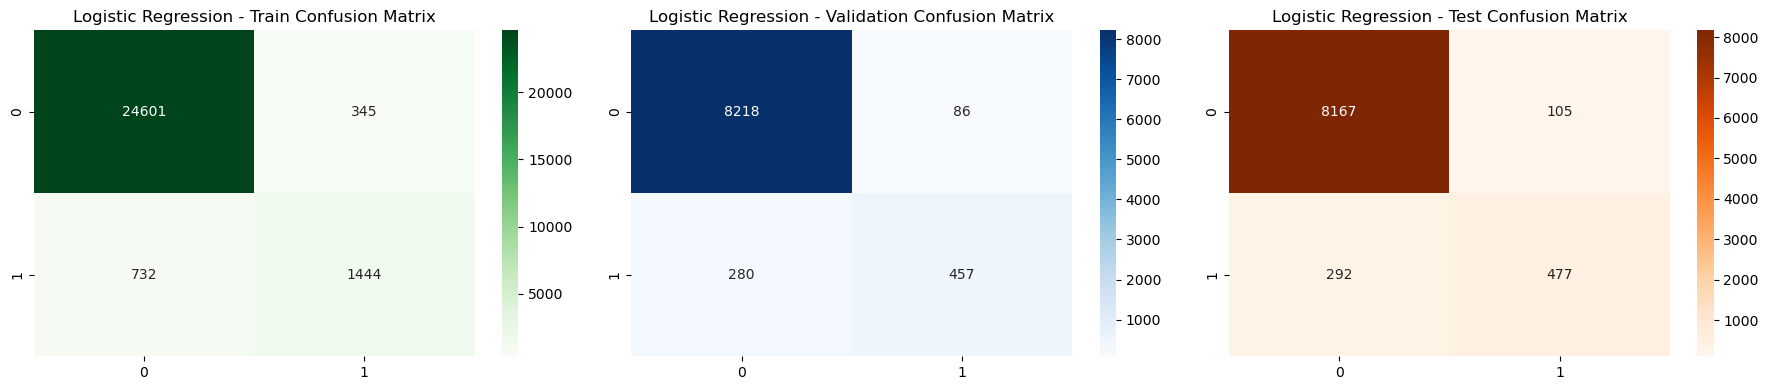


🔵 Random Forest - 5-Fold CV Training on Train Set
Fold 1 - F1-score: 0.9800
Fold 2 - F1-score: 0.9770
Fold 3 - F1-score: 0.9801
Fold 4 - F1-score: 0.9801
Fold 5 - F1-score: 0.9766

🔷 Random Forest - Train Set Results
[[24935    11]
 [  109  2067]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       0.99      0.95      0.97      2176

    accuracy                           1.00     27122
   macro avg       1.00      0.97      0.98     27122
weighted avg       1.00      1.00      1.00     27122

Accuracy (Train): 0.9956
F1-Score (Weighted, Train): 0.9955
F1-Score (Macro, Train): 0.9847
Log Loss (Train): 0.0130

🟡 Random Forest - Validation Set Results
[[8301    3]
 [ 164  573]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8304
           1       0.99      0.78      0.87       737

    accuracy                           0.98      9041
   macro avg       0

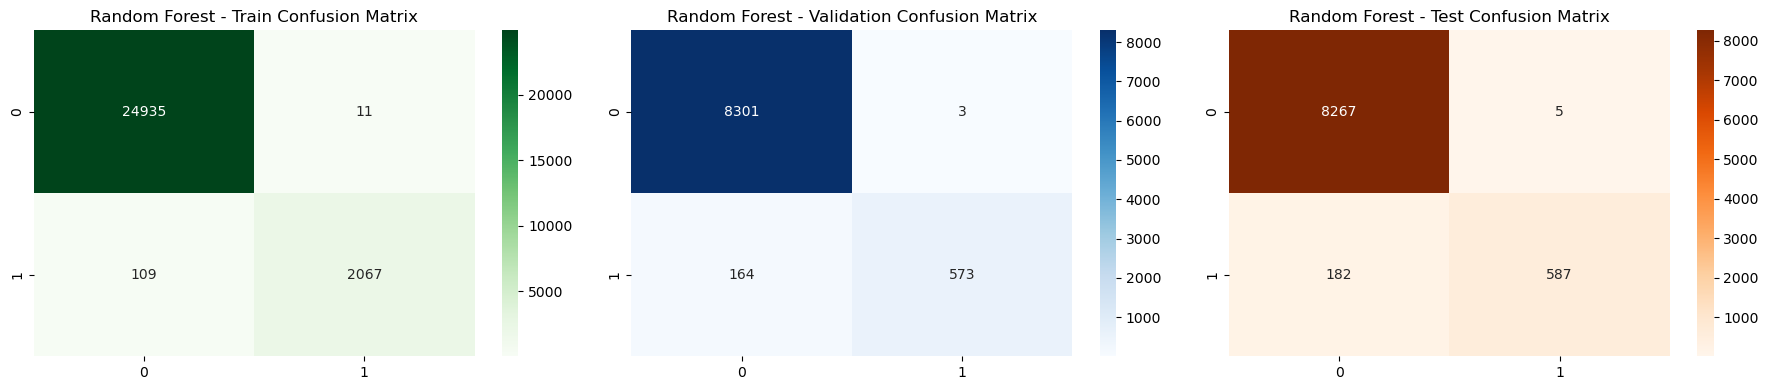


🔵 XGBoost - 5-Fold CV Training on Train Set
Fold 1 - F1-score: 0.9771


C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - F1-score: 0.9765
Fold 3 - F1-score: 0.9763
Fold 4 - F1-score: 0.9772


C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 - F1-score: 0.9761

🔷 XGBoost - Train Set Results
[[24910    36]
 [   90  2086]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24946
           1       0.98      0.96      0.97      2176

    accuracy                           1.00     27122
   macro avg       0.99      0.98      0.98     27122
weighted avg       1.00      1.00      1.00     27122

Accuracy (Train): 0.9954
F1-Score (Weighted, Train): 0.9953
F1-Score (Macro, Train): 0.9841
Log Loss (Train): 0.0060

🟡 XGBoost - Validation Set Results
[[8248   56]
 [ 145  592]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8304
           1       0.91      0.80      0.85       737

    accuracy                           0.98      9041
   macro avg       0.95      0.90      0.92      9041
weighted avg       0.98      0.98      0.98      9041

Accuracy (Val): 0.9778
F1-Score (Weighted, Val): 0.9771
F1-Score (Macro, Val):

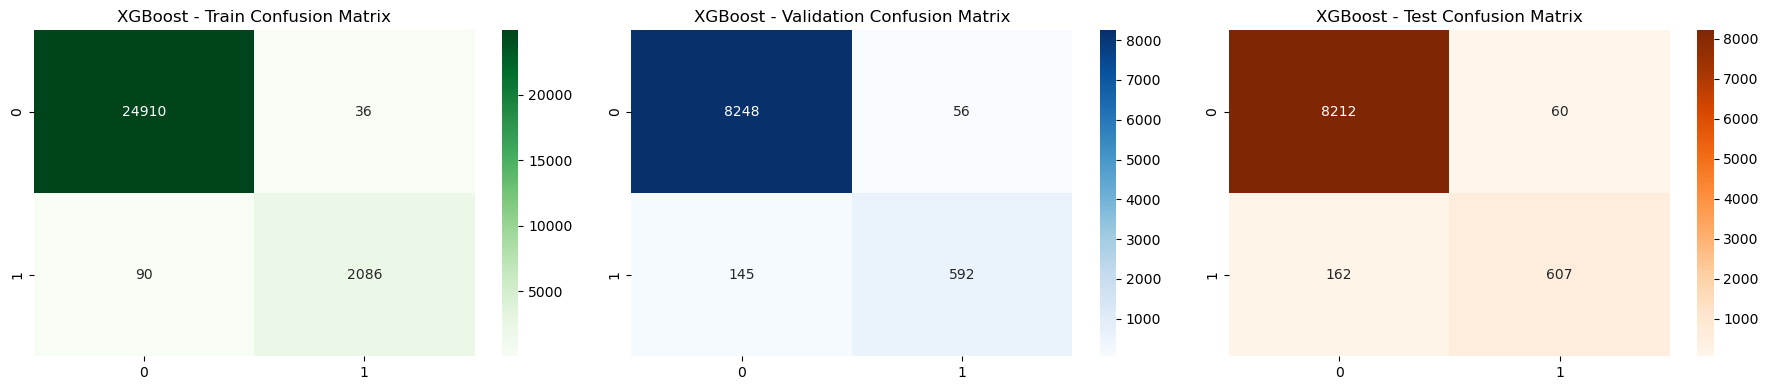

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ---------------------- DATA PREPROCESSING ----------------------

def encode(df):
    df = df.copy()
    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df

train = encode(train)
val = encode(val)
test = encode(test)

X_train_full = train.drop('credit_card_default', axis=1)
y_train_full = train['credit_card_default']
X_val = val.drop('credit_card_default', axis=1)
y_val = val['credit_card_default']
X_test = test.drop('credit_card_default', axis=1)
y_test = test['credit_card_default']

# ---------------------- MODEL TRAIN + VAL + TEST ----------------------

def train_with_cv_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, k=5):
    print(f"\n🔵 {model_name} - {k}-Fold CV Training on Train Set")

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    best_model = None
    best_f1 = -1

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_pred, average='weighted')

        print(f"Fold {fold+1} - F1-score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_model = model


        # Olasılık tahminleri varsa log loss için
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_tr)
        y_test_proba = model.predict_proba(X_test)
        y_val_proba = model.predict_proba(X_val)
    else:
        y_train_proba = y_test_proba = y_val_proba = None

    
    # TRAIN PREDICTION
    y_train_pred = best_model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    print(f"\n🔷 {model_name} - Train Set Results")
    print(cm_train)
    print(classification_report(y_train, y_train_pred))
    print(f"Accuracy (Train): {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"F1-Score (Weighted, Train): {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1-Score (Macro, Train): {f1_score(y_train, y_train_pred, average='macro'):.4f}")
    if y_train_proba is not None:
        print(f"Log Loss (Train): {log_loss(y_tr, y_train_proba):.4f}")
        
    # VALIDATION PREDICTION
    y_val_pred = best_model.predict(X_val)
    cm_val = confusion_matrix(y_val, y_val_pred)
    print(f"\n🟡 {model_name} - Validation Set Results")
    print(cm_val)
    print(classification_report(y_val, y_val_pred))
    print(f"Accuracy (Val): {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"F1-Score (Weighted, Val): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
    print(f"F1-Score (Macro, Val): {f1_score(y_val, y_val_pred, average='macro'):.4f}")
    if y_test_proba is not None:
        print(f"Log Loss (Test): {log_loss(y_test, y_test_proba):.4f}")
        
    # TEST PREDICTION
    y_test_pred = best_model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    print(f"\n🟠 {model_name} - Test Set Results")
    print(cm_test)
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"F1-Score (Weighted, Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1-Score (Macro, Test): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    if y_val_proba is not None:
        print(f"Log Loss (Val): {log_loss(y_val, y_val_proba):.4f}")
    # GÖRSELLEŞTİRME
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', ax=axes[0])
    axes[0].set_title(f'{model_name} - Train Confusion Matrix')

    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'{model_name} - Validation Confusion Matrix')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
    axes[2].set_title(f'{model_name} - Test Confusion Matrix')

    plt.tight_layout()
    plt.show()

# ---------------------- MODELLERİ ÇALIŞTIR ----------------------

models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=200, random_state=42), "Random Forest"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), "XGBoost")
]

for model, name in models:
    train_with_cv_and_evaluate(model, name, X_train_full, y_train_full, X_val, y_val, X_test, y_test)


# Lasso Regression

Train Confusion Matrix:
[[23979   967]
 [  597 24349]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     24946
           1       0.96      0.98      0.97     24946

    accuracy                           0.97     49892
   macro avg       0.97      0.97      0.97     49892
weighted avg       0.97      0.97      0.97     49892

Accuracy (Train): 0.9687
F1-Score (Macro, Train): 0.9687
F1-Score (Weighted, Train): 0.9687
Log Loss (Train): 0.0748

Test Confusion Matrix:
[[7950  322]
 [  61  708]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      8272
           1       0.69      0.92      0.79       769

    accuracy                           0.96      9041
   macro avg       0.84      0.94      0.88      9041
weighted avg       0.97      0.96      0.96      9041

Accuracy (Test): 0.9576
F1-Score (Macro, Test): 0.8818
F1-Score (Weighted, Test): 0.9604
Log Loss (Test): 0.0894

Validatio

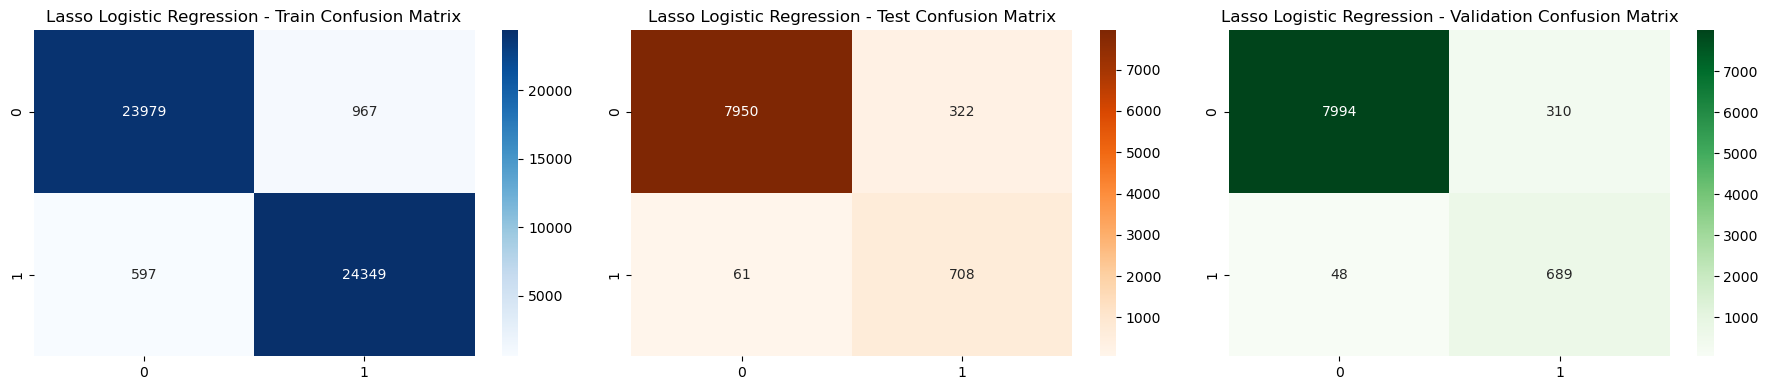

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare training data
X_train1 = train_smote.drop('credit_card_default', axis=1)
y_train1 = train_smote['credit_card_default']

# Encode categorical columns in training data
for col in X_train1.select_dtypes(include='object').columns:
    X_train1[col] = LabelEncoder().fit_transform(X_train1[col])

# Fit Lasso (L1-penalized logistic regression) model
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso_model.fit(X_train1, y_train1)

# Predict on train, test, and validation sets
y_train_pred = lasso_model.predict(X_train1)
y_test_pred = lasso_model.predict(X_test)
y_val_pred = lasso_model.predict(X_val)

# Predict probabilities if available (for log loss)
if hasattr(lasso_model, "predict_proba"):
    y_train_proba = lasso_model.predict_proba(X_train1)
    y_test_proba = lasso_model.predict_proba(X_test)
    y_val_proba = lasso_model.predict_proba(X_val)
else:
    y_train_proba = y_test_proba = y_val_proba = None

# Print training metrics
print("Train Confusion Matrix:")
print(confusion_matrix(y_train1, y_train_pred))
print(classification_report(y_train1, y_train_pred))
print(f"Accuracy (Train): {accuracy_score(y_train1, y_train_pred):.4f}")
print(f"F1-Score (Macro, Train): {f1_score(y_train1, y_train_pred, average='macro'):.4f}")
print(f"F1-Score (Weighted, Train): {f1_score(y_train1, y_train_pred, average='weighted'):.4f}")
if y_train_proba is not None:
    print(f"Log Loss (Train): {log_loss(y_train1, y_train_proba):.4f}")

# Print test metrics
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(f"Accuracy (Test): {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score (Macro, Test): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"F1-Score (Weighted, Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
if y_test_proba is not None:
    print(f"Log Loss (Test): {log_loss(y_test, y_test_proba):.4f}")

# Print validation metrics
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print(f"Accuracy (Val): {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1-Score (Macro, Val): {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"F1-Score (Weighted, Val): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
if y_val_proba is not None:
    print(f"Log Loss (Val): {log_loss(y_val, y_val_proba):.4f}")

# Plot confusion matrices
cm_train = confusion_matrix(y_train1, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Lasso Logistic Regression - Train Confusion Matrix')

sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap='Oranges')
axes[1].set_title('Lasso Logistic Regression - Test Confusion Matrix')

sns.heatmap(cm_val, annot=True, fmt='d', ax=axes[2], cmap='Greens')
axes[2].set_title('Lasso Logistic Regression - Validation Confusion Matrix')

plt.tight_layout()
plt.show()


# Eski Kodlar (Önemsiz)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df= pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied.csv')

# 3. Kategorik değişkenleri Label Encoding yapalım
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    

# 5. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 6. Eğitim/Test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Logistic Regression Modeli
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 8. Test setinde tahmin
y_pred = model.predict(X_test)

# 9. Başarı skorları
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9680437198962579

Confusion Matrix:
 [[8129  176]
 [ 169 2322]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8305
           1       0.93      0.93      0.93      2491

    accuracy                           0.97     10796
   macro avg       0.95      0.96      0.96     10796
weighted avg       0.97      0.97      0.97     10796



In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df= pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied7030.csv')

# 3. Kategorik değişkenleri Label Encoding yapalım
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    

# 5. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 6. Eğitim/Test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Logistic Regression Modeli
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 8. Test setinde tahmin
y_pred = model.predict(X_test)

# 9. Başarı skorları
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9661502189289323

Confusion Matrix:
 [[8095  210]
 [ 192 3379]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      8305
           1       0.94      0.95      0.94      3571

    accuracy                           0.97     11876
   macro avg       0.96      0.96      0.96     11876
weighted avg       0.97      0.97      0.97     11876



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df= pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied6040.csv')

# 3. Kategorik değişkenleri Label Encoding yapalım
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    

# 5. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 6. Eğitim/Test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Logistic Regression Modeli
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 8. Test setinde tahmin
y_pred = model.predict(X_test)

# 9. Başarı skorları
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9676977431682169

Confusion Matrix:
 [[8056  249]
 [ 199 5365]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      8305
           1       0.96      0.96      0.96      5564

    accuracy                           0.97     13869
   macro avg       0.97      0.97      0.97     13869
weighted avg       0.97      0.97      0.97     13869



In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df= pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied4060.csv')

# 3. Kategorik değişkenleri Label Encoding yapalım
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    

# 5. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 6. Eğitim/Test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Logistic Regression Modeli
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 8. Test setinde tahmin
y_pred = model.predict(X_test)

# 9. Başarı skorları
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9735830212234706

Confusion Matrix:
 [[ 7971   334]
 [  195 11525]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      8305
           1       0.97      0.98      0.98     11720

    accuracy                           0.97     20025
   macro avg       0.97      0.97      0.97     20025
weighted avg       0.97      0.97      0.97     20025



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df= pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied3070.csv')

# 3. Kategorik değişkenleri Label Encoding yapalım
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    

# 5. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 6. Eğitim/Test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Logistic Regression Modeli
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# 8. Test setinde tahmin
y_pred = model.predict(X_test)

# 9. Başarı skorları
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9782763133295943

Confusion Matrix:
 [[ 7914   390]
 [  191 18250]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      8304
           1       0.98      0.99      0.98     18441

    accuracy                           0.98     26745
   macro avg       0.98      0.97      0.97     26745
weighted avg       0.98      0.98      0.98     26745



# Random Forest Run

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans
print("🔎 Random Forest Sonuçları:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_rf))



🔎 Random Forest Sonuçları:
[[8161  144]
 [  81 8223]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8305
           1       0.98      0.99      0.99      8304

    accuracy                           0.99     16609
   macro avg       0.99      0.99      0.99     16609
weighted avg       0.99      0.99      0.99     16609

Doğruluk (Accuracy): 0.986453127822265


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied7030.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans
print("🔎 Random Forest Sonuçları:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_rf))


🔎 Random Forest Sonuçları:
[[8218   87]
 [ 129 3442]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8305
           1       0.98      0.96      0.97      3571

    accuracy                           0.98     11876
   macro avg       0.98      0.98      0.98     11876
weighted avg       0.98      0.98      0.98     11876

Doğruluk (Accuracy): 0.9818120579319636


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied6040.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans
print("🔎 Random Forest Sonuçları:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_rf))


🔎 Random Forest Sonuçları:
[[8197  108]
 [ 102 5462]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8305
           1       0.98      0.98      0.98      5564

    accuracy                           0.98     13869
   macro avg       0.98      0.98      0.98     13869
weighted avg       0.98      0.98      0.98     13869

Doğruluk (Accuracy): 0.9848583171101016


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied4060.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans
print("🔎 Random Forest Sonuçları:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_rf))


🔎 Random Forest Sonuçları:
[[ 8150   155]
 [   66 11654]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8305
           1       0.99      0.99      0.99     11720

    accuracy                           0.99     20025
   macro avg       0.99      0.99      0.99     20025
weighted avg       0.99      0.99      0.99     20025

Doğruluk (Accuracy): 0.98896379525593


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied3070.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest modeli
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Performans
print("🔎 Random Forest Sonuçları:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_rf))


🔎 Random Forest Sonuçları:
[[ 8132   172]
 [   64 18377]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8304
           1       0.99      1.00      0.99     18441

    accuracy                           0.99     26745
   macro avg       0.99      0.99      0.99     26745
weighted avg       0.99      0.99      0.99     26745

Doğruluk (Accuracy): 0.9911759207328472


# XGBoost Run

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Performans
print("🔎 XGBoost Sonuçları:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_xgb))

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:32:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Sonuçları:
[[8185  120]
 [  86 8218]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8305
           1       0.99      0.99      0.99      8304

    accuracy                           0.99     16609
   macro avg       0.99      0.99      0.99     16609
weighted avg       0.99      0.99      0.99     16609

Doğruluk (Accuracy): 0.9875970859172738


In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied7030.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Performans
print("🔎 XGBoost Sonuçları:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_xgb))

🔎 XGBoost Sonuçları:
[[8206   99]
 [ 105 3466]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8305
           1       0.97      0.97      0.97      3571

    accuracy                           0.98     11876
   macro avg       0.98      0.98      0.98     11876
weighted avg       0.98      0.98      0.98     11876

Doğruluk (Accuracy): 0.9828224991579656


C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied6040.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Performans
print("🔎 XGBoost Sonuçları:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_xgb))

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Sonuçları:
[[8176  129]
 [ 103 5461]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8305
           1       0.98      0.98      0.98      5564

    accuracy                           0.98     13869
   macro avg       0.98      0.98      0.98     13869
weighted avg       0.98      0.98      0.98     13869

Doğruluk (Accuracy): 0.9832720455692552


In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied4060.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Performans
print("🔎 XGBoost Sonuçları:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_xgb))

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Sonuçları:
[[ 8167   138]
 [   85 11635]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8305
           1       0.99      0.99      0.99     11720

    accuracy                           0.99     20025
   macro avg       0.99      0.99      0.99     20025
weighted avg       0.99      0.99      0.99     20025

Doğruluk (Accuracy): 0.9888639200998751


In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

df_resampled_final = pd.read_csv(r'C:\Users\Utku\Desktop\train_smote_applied3070.csv')

# X ve y'yi ayır
X = df_resampled_final.drop(columns=['credit_card_default'])
y = df_resampled_final['credit_card_default']

# Train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# XGBoost modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Performans
print("🔎 XGBoost Sonuçları:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_xgb))

C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔎 XGBoost Sonuçları:
[[ 8168   136]
 [  102 18339]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8304
           1       0.99      0.99      0.99     18441

    accuracy                           0.99     26745
   macro avg       0.99      0.99      0.99     26745
weighted avg       0.99      0.99      0.99     26745

Doğruluk (Accuracy): 0.9911011404000748


# Cross Validation

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Veri setini oku
df = pd.read_csv(r'C:\Users\Utku\Desktop\train_full.csv')

# 2. Kategorik değişkenleri Label Encoding ile sayısal hale getir
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 3. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# Ölçekleme (opsiyonel ama önerilir)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# 4. Stratified K-Fold Cross-Validation (5 katlı)
model = LogisticRegression(max_iter=1000, solver='lbfgs')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=cv)

# Classification report
report = classification_report(y, y_pred_cv)
print("Classification Report (Cross-Validation):\n")
print(report)



Classification Report (Cross-Validation):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41522
           1       0.89      0.80      0.85      3682

    accuracy                           0.98     45204
   macro avg       0.94      0.90      0.92     45204
weighted avg       0.98      0.98      0.98     45204



In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Veri setini oku
df = pd.read_csv(r'C:\Users\Utku\Desktop\train_full.csv')

# 2. Kategorik değişkenleri Label Encoding ile sayısal hale getir
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 3. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 4. Ölçekleme (opsiyonel ama RandomForest için zorunlu değil — yine de tutuyoruz)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Random Forest Modeli ve Cross-Validation
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=cv)

# 6. Rapor
print("Classification Report (Random Forest + CV):\n")
print(classification_report(y, y_pred_cv))


Classification Report (Random Forest + CV):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41522
           1       0.99      0.77      0.86      3682

    accuracy                           0.98     45204
   macro avg       0.98      0.88      0.93     45204
weighted avg       0.98      0.98      0.98     45204



In [15]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. Veri setini oku
df = pd.read_csv(r'C:\Users\Utku\Desktop\train_full.csv')

# 2. Kategorik değişkenleri Label Encoding ile sayısal hale getir
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 3. Özellikler ve hedef değişken ayrımı
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 4. Ölçekleme (opsiyonel ama genellikle performansı artırır)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. XGBoost Modeli ve Cross-Validation
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=cv)

# 6. Rapor
print("Classification Report (XGBoost + CV):\n")
print(classification_report(y, y_pred_cv))


C:\Users\UTKU\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost + CV):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41522
           1       0.91      0.80      0.85      3682

    accuracy                           0.98     45204
   macro avg       0.95      0.90      0.92     45204
weighted avg       0.98      0.98      0.98     45204



# Lasso Regression

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Veriyi oku
df = pd.read_csv(r'C:\Users\Utku\Desktop\train_full.csv')

# 2. Label Encoding
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 3. Özellikler ve hedef değişken
X = df.drop(columns=['credit_card_default'])
y = df['credit_card_default']

# 4. Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Özellikleri ölçekle (L1 penalty’de scaling önemli)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Lasso Logistic Regression (L1 penalty)
model = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=5000,
    #class_weight='balanced'  # dengesiz veri varsa açabilirsin
)
model.fit(X_train_scaled, y_train)

# 7. Tahmin yap
y_pred = model.predict(X_test_scaled)

# 8. Performans metrikleri
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# 9. Sonuçları yazdır
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.9762194447516868

Confusion Matrix:
 [[8239   66]
 [ 149  587]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      8305
           1       0.90      0.80      0.85       736

    accuracy                           0.98      9041
   macro avg       0.94      0.89      0.92      9041
weighted avg       0.98      0.98      0.98      9041

